In [1]:
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

MATRIX_FILE = "training_data/K562/rep2/ENCFF144PUF_all_matrix.tsv"
NUM_TRUE_LABELS = 171834
COEFF_OUTPUT = "training_data/K562/rep2/coeff.tsv"
PLOT_1_TITLE = "K562 rep 2 LogisticReg, auc "
PLOT_1_OUTPUT = "K562_rep2_roc.png"
PLOT_CV_TITLE = "K562 rep 2 LogisticRegCV, auc "
PLOT_CV_OUTPUT = "K562_rep2_roc_CV.png"


X_raw = np.loadtxt(MATRIX_FILE, delimiter='\t')
X_size = X_raw.shape[0]
y = np.zeros((X_size, ), dtype=np.uint8)

shuffle_ids = np.random.permutation(X_size)

for i in range(NUM_TRUE_LABELS):
    y[i] = 1

X = normalize(X_raw)
X = X[shuffle_ids]
y = y[shuffle_ids]

X_train = X[:X_size/2]
y_train = y[:X_size/2]

X_test = X[X_size/2:]
y_test = y[X_size/2:]

In [ ]:
def 

In [2]:
lr = LogisticRegression(C=1.0)
lr.fit(X_train, y_train)
results = lr.predict(X_test)

In [3]:
diff = results - y_test
total = 0
false_p = 0
false_n = 0
for i in diff:
    if i == 255:
        false_n += 1
        total += 1
    if i == 1:
        false_p += 1
        total += i

print "Training set score =", lr.score(X_train, y_train)
print "Test set score =", lr.score(X_test, y_test)

print "False rate =", float(total)/(X_size/2)
print "False positive rate =", float(false_p)/(X_size/2)
print "False negative rate =",float(false_n)/(X_size/2)

Training set score = 0.801612757635
Test set score = 0.798262083574
False rate = 0.201739130435
False positive rate = 0.10534677298
False negative rate = 0.0963923574545


In [4]:
coefs = lr.coef_
motif_list = pd.read_csv("human_pwm_ids_sorted.txt", sep=' ', header=None)
sort_ids = np.flip(np.argsort(coefs), 1)
motif_list['coeff'] = coefs.T
# print motif_list.iloc[sort_ids[0][:50], [1,2,3]]

save_results = motif_list.iloc[sort_ids[0], [1,2,3]]
save_results.to_csv(COEFF_OUTPUT, sep='\t')

In [5]:
y_score = lr.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
auc = roc_auc_score(y_test, y_score[:, 1])

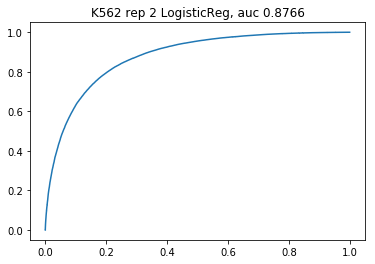

In [6]:
plt.plot(fpr, tpr)
PLOT_1_TITLE = PLOT_1_TITLE + "%.4f" %auc
plt.title(PLOT_1_TITLE)
plt.savefig(PLOT_1_OUTPUT)
plt.show()

In [7]:
clfcv = LogisticRegressionCV(cv=5)
clfcv.fit(X_train, y_train)
print "Score:", clfcv.score(X_test, y_test)

y_score = clfcv.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])

Score: 0.798274119006


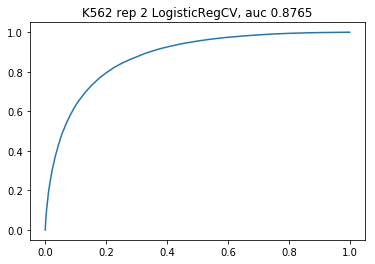

In [8]:
auc = roc_auc_score(y_test, y_score[:, 1])

plt.plot(fpr, tpr)
PLOT_CV_TITLE = PLOT_CV_TITLE + "%.4f" %auc
plt.title(PLOT_CV_TITLE)
plt.savefig(PLOT_CV_OUTPUT)
plt.show()

In [9]:
clfcv.C_

array([ 2.7825594])